## Load Stats about Pairs File

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Cell 2: Load and analyze pairs
import pandas as pd
top3_path = "/home/bjangley/VPR/mast3r-v2/mined_step50/spagna_matches_inliers_fm_top3_anchors_per_query_per_anchorseq.csv"
df = pd.read_csv(top3_path)

# # Group by anchor_seq and query_seq and count the number of pairs
# pair_counts = df.groupby(['anchor_seq', 'query_seq']).size().reset_index(name='num_pairs')

# # Print the counts
# print(pair_counts)
# print("Total number of pairs:", pair_counts['num_pairs'].sum())



# Group by anchor_seq and query_seq and compute median and mean for num_inliers
inliers_stats = df.groupby(['anchor_seq', 'query_seq'])['num_inliers'].agg(['mean', 'median']).reset_index()

# Print the results
print("Per Anchor-Query Sequence Median and Mean num_inliers:")
print(inliers_stats)

Per Anchor-Query Sequence Median and Mean num_inliers:
    anchor_seq  query_seq         mean  median
0            0          3  1142.383333  1392.5
1            0         10  1162.525000  1478.5
2            4          3   737.058333   724.5
3            4          5   568.775000   340.0
4            4         10   950.066667   875.5
5            4         11  1147.833333  1142.0
6            4         12   152.891667    99.5
7            4         19   580.333333   591.5
8            7         14   495.516667   273.5
9           13         15   776.158333  1029.5
10          20          2   956.008333   890.0
11          20         21   453.222222   362.0


In [2]:
# Group by anchor_seq and query_seq and count the number of pairs
pair_counts = df.groupby(['anchor_seq', 'query_seq']).size().reset_index(name='num_pairs')

# Count unique anchors and queries per anchor-query sequence combination
unique_counts = df.groupby(['anchor_seq', 'query_seq']).agg({
    'anchor_idx': 'nunique',
    'query_idx': 'nunique'
}).reset_index()
unique_counts.columns = ['anchor_seq', 'query_seq', 'unique_anchors', 'unique_queries']

# Merge the counts
detailed_counts = pair_counts.merge(unique_counts, on=['anchor_seq', 'query_seq'])

# Print the detailed counts
print("Detailed Pair Counts per Anchor-Query Sequence:")
print(detailed_counts)
print("\nTotal number of pairs:", detailed_counts['num_pairs'].sum())
print("Total unique anchor sequences:", detailed_counts['anchor_seq'].nunique())
print("Total unique query sequences:", detailed_counts['query_seq'].nunique())




Detailed Pair Counts per Anchor-Query Sequence:
    anchor_seq  query_seq  num_pairs  unique_anchors  unique_queries
0            0          3        120              26              40
1            0         10        120              26              40
2            4          3        120              19              40
3            4          5        120              13              40
4            4         10        120              18              40
5            4         11        120              37              40
6            4         12        120              18              40
7            4         19        120               9              40
8            7         14        120              28              40
9           13         15        120              22              40
10          20          2        120              24              40
11          20         21         27               9               9

Total number of pairs: 1347
Total unique anchor sequen

In [3]:
def load_statistics(pointcloud_type, base_path="results_step50"):
    """
    Load statistics for a specified point cloud type.
    Auto-detects column structure from the data.
    """
    # Construct the file path based on the point cloud type
    statistics_file = f"{base_path}/spagna_{pointcloud_type}_statistics.txt"
    
    try:
        # First, read without column names to detect structure
        df_temp = pd.read_csv(statistics_file, delim_whitespace=True, header=None)
        num_columns = len(df_temp.columns)
        
        # Define column names based on detected structure
        if num_columns == 15:
            # Basic methods (mast3r, lidar) - updated structure
            columns = [
                "query_seq", "anchor_seq", "query_idx", "anchor_idx",
                "num_matches", "num_inliers", "num_overlapping", "median_depth",
                "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                "distance_anchor_query", "status"
            ]
        elif num_columns == 17:
            # Scaled methods with single scale (mast3r_scaled_v3, mast3r_scaled_icp) - updated structure
            columns = [
                "query_seq", "anchor_seq", "query_idx", "anchor_idx",
                "num_matches", "num_inliers", "num_overlapping", "median_depth",
                "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                "distance_anchor_query", "pointmap_error", "scale", "status"
            ]
        elif num_columns == 19:
            # Scaled methods with three scales (mast3r_scaled_v4) - updated structure
            columns = [
                "query_seq", "anchor_seq", "query_idx", "anchor_idx",
                "num_matches", "num_inliers", "num_overlapping", "median_depth",
                "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                "distance_anchor_query", "pointmap_error", 
                "scale_x", "scale_y", "scale_z", "status"
            ]
        else:
            raise ValueError(f"Unexpected number of columns ({num_columns}) for {pointcloud_type}")
        
        # Reload with proper column names
        df = pd.read_csv(statistics_file, delim_whitespace=True, names=columns)
        print(f"Loaded statistics for {pointcloud_type}: {num_columns} columns detected")
        return df
        
    except FileNotFoundError:
        print(f"Error: File not found for point cloud type: {pointcloud_type}")
        return None

In [22]:
import pandas as pd
import numpy as np
# Set pandas display options to show all columns in one line
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load all datasets
results = ['mast3r', 'lidar', 'mast3r_scaled_v3', 'mast3r_scaled_v4', 'mast3r_scaled_icp']
loaded_data = {}

for pointcloud_type in results:
    df = load_statistics(pointcloud_type)
    if df is not None:
        # Convert numeric columns
        numeric_columns = ["num_matches", "num_inliers","n_overlapping", "median_depth", "x_error", "y_error", "z_error", "pos_error", "rot_error"]
        if "pointmap_error" in df.columns:
            numeric_columns.append("pointmap_error")
        if "distance_anchor_query" in df.columns:
            numeric_columns.append("distance_anchor_query")
        
        # Add scale columns
        scale_cols = [col for col in df.columns if col.startswith("scale")]
        numeric_columns.extend(scale_cols)
        
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        
        loaded_data[pointcloud_type] = df

# Table 1: Success rate and num_inliers (median)
table1_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table1_data.append({
        'method': pointcloud_type,
        'n_success': len(ok_pairs),
        'n_total': len(df),
        'success_rate': len(ok_pairs) / len(df) if len(df) > 0 else 0,
        'num_inliers_median': ok_pairs['num_inliers'].median() if len(ok_pairs) > 0 else np.nan
    })

table1 = pd.DataFrame(table1_data)
print("Table 1: Success Rates and Inliers")
print(table1)
print()

# Table 2: Position and rotation errors (median)
table2_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table2_data.append({
        'method': pointcloud_type,
        'pos_error_median': ok_pairs['pos_error'].median() if len(ok_pairs) > 0 else np.nan,
        'x_error_median': ok_pairs['x_error'].median() if len(ok_pairs) > 0 else np.nan,
        'y_error_median': ok_pairs['y_error'].median() if len(ok_pairs) > 0 else np.nan,
        'z_error_median': ok_pairs['z_error'].median() if len(ok_pairs) > 0 else np.nan,
        'rot_error_median': ok_pairs['rot_error'].median() if len(ok_pairs) > 0 else np.nan
    })

table2 = pd.DataFrame(table2_data)
print("Table 2: Position and Rotation Errors (Median)")
print(table2.to_string(index=False))
print()

# Table 3: Distance and scales (mean and median)
table3_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    
    row = {
        'method': pointcloud_type,
        'distance_mean': ok_pairs['median_depth'].mean() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
        'distance_median': ok_pairs['median_depth'].median() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
    }
    
    # Add scale statistics
    if 'scale' in ok_pairs.columns:
        # row['scale_mean'] = ok_pairs['scale'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_median'] = ok_pairs['scale'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_x' in ok_pairs.columns:
        # row['scale_x_mean'] = ok_pairs['scale_x'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_x_median'] = ok_pairs['scale_x'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_y' in ok_pairs.columns:
        # row['scale_y_mean'] = ok_pairs['scale_y'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_y_median'] = ok_pairs['scale_y'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_z' in ok_pairs.columns:
        # row['scale_z_mean'] = ok_pairs['scale_z'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_z_median'] = ok_pairs['scale_z'].median() if len(ok_pairs) > 0 else np.nan
    
    table3_data.append(row)

table3 = pd.DataFrame(table3_data)
print("Table 3: Distance and Scale Statistics")
print(table3.to_string(index=False))

Loaded statistics for mast3r: 15 columns detected
Loaded statistics for lidar: 15 columns detected
Loaded statistics for mast3r_scaled_v3: 17 columns detected
Loaded statistics for mast3r_scaled_v4: 19 columns detected
Loaded statistics for mast3r_scaled_icp: 17 columns detected
Table 1: Success Rates and Inliers
              method  n_success  n_total  success_rate  num_inliers_median
0             mast3r       1000     1347      0.742390               740.5
1              lidar        996     1347      0.739421               743.0
2   mast3r_scaled_v3       1000     1347      0.742390               740.5
3   mast3r_scaled_v4        998     1347      0.740906               742.0
4  mast3r_scaled_icp       1000     1347      0.742390               740.5

Table 2: Position and Rotation Errors (Median)
           method  pos_error_median  x_error_median  y_error_median  z_error_median  rot_error_median
           mast3r          5.578290        2.005828        0.220616        3.995474  

Analyzing dataset: lidar
Total pairs: 1347, Successful pairs: 996
Binning by: num_inliers
Annotation metrics: ['num_inliers', 'num_overlapping']


/tmp/ipykernel_1571189/3017146614.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)


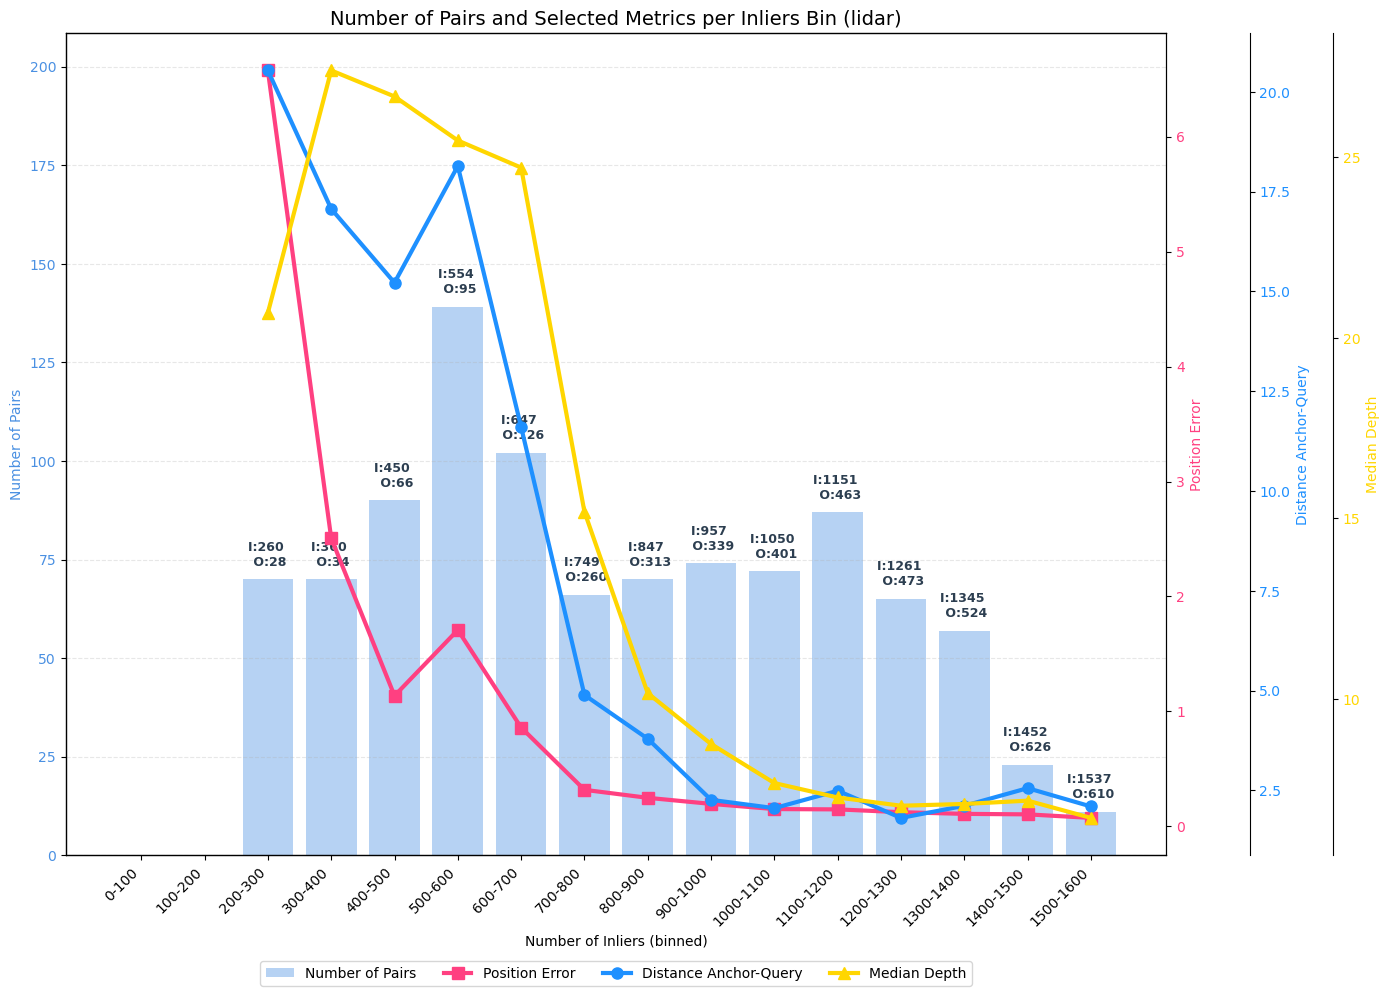


Available metrics in this dataset:
  - num_matches
  - num_inliers
  - num_overlapping
  - median_depth
  - x_error
  - y_error
  - z_error
  - pos_error
  - rot_error
  - distance_anchor_query
  - num_inliers_bin


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
dataset_to_plot = 'lidar'  # Change this to any method
bin_width = 100  # Adjust bin width as needed
bin_by = 'num_inliers'  # Change this to 'num_matches', 'num_inliers', or 'num_overlapping'

# Choose which metrics to plot with better color palette
metrics_to_plot = {
    'pos_error': {'color': '#FF4081', 'marker': 's', 'label': 'Position Error'},  # Bright pink
    'distance_anchor_query': {'color': '#1E90FF', 'marker': 'o', 'label': 'Distance Anchor-Query'},  # Bright blue

    'median_depth': {'color': '#FFD600', 'marker': '^', 'label': 'Median Depth'},  # Bright yellow
    # Add more metrics as needed
    # 'rot_error': {'color': '#FF7043', 'marker': 'D', 'label': 'Rotation Error'},  # Bright orange
    # 'num_inliers': {'color': '#00E676', 'marker': 'v', 'label': 'Number of Inliers'},  # Bright green
}

# Choose which metrics to show as annotations on bars (can be multiple)
annotation_metrics = ['num_inliers', 'num_overlapping']  # Change to any combination of metrics

# Get the dataset and filter for successful pairs only
df = loaded_data[dataset_to_plot]
df_ok = df[df['status'] == 'OK']  # Only successful pairs for plotting

print(f"Analyzing dataset: {dataset_to_plot}")
print(f"Total pairs: {len(df)}, Successful pairs: {len(df_ok)}")
print(f"Binning by: {bin_by}")
print(f"Annotation metrics: {annotation_metrics}")

# Validate binning column exists
if bin_by not in df_ok.columns:
    print(f"Error: Column '{bin_by}' not found in dataset!")
    print(f"Available columns: {list(df_ok.columns)}")
else:
    # Create bins based on selected binning column
    bins = range(0, int(df_ok[bin_by].max()) + bin_width, bin_width)
    bin_column = f"{bin_by}_bin"
    df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)

    # Group by the bins and compute statistics
    grouped = df_ok.groupby(bin_column)
    count_by_bin = grouped.size()
    
    # Compute median for annotation metrics
    annotation_medians = {}
    for metric in annotation_metrics:
        if metric in df_ok.columns:
            annotation_medians[metric] = grouped[metric].median()

    # Compute median for each selected metric to plot
    metric_medians = {}
    for metric in metrics_to_plot.keys():
        if metric in df_ok.columns:
            metric_medians[metric] = grouped[metric].median()

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 10))

    # Bar plot: number of pairs per bin (left y-axis) - More transparent
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, label="Number of Pairs")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.tick_params(axis="y", labelcolor="#4A90E2")
    
    # Dynamic x-axis label based on binning variable
    x_label_map = {
        'num_matches': 'Number of Matches (binned)',
        'num_inliers': 'Number of Inliers (binned)',
        'num_overlapping': 'Number of Overlapping Points (binned)'
    }
    x_label = x_label_map.get(bin_by, f'{bin_by} (binned)')
    ax1.set_xlabel(x_label)
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # Annotate bars with median values of selected metrics
    for i, bar in enumerate(bars):
        annotation_text = []
        for metric in annotation_metrics:
            if metric in annotation_medians:
                median_value = annotation_medians[metric].iloc[i]
                if not pd.isna(median_value):
                    # Create short labels for annotations
                    metric_label_map = {
                        'num_inliers': 'I',
                        'num_matches': 'M', 
                        'num_overlapping': 'O'
                    }
                    short_label = metric_label_map.get(metric, metric[:1].upper())
                    annotation_text.append(f"{short_label}:{median_value:.0f}")
        
        if annotation_text:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,  # Center on bar
                bar.get_height() + max(count_by_bin) * 0.02,  # Slightly above bar
                " \n ".join(annotation_text),  # Join multiple metrics with separator
                ha="center", va="bottom", fontsize=9, color="#2C3E50", weight="bold"
            )

    # Create additional y-axes for each metric
    axes = [ax1]  # Start with the main axis
    line_plots = []

    for i, (metric, config) in enumerate(metrics_to_plot.items()):
        if metric in metric_medians:
            # Create new y-axis for each metric (except the first one)
            if i == 0:
                ax_metric = ax1.twinx()
            else:
                ax_metric = ax1.twinx()
                # Offset additional axes
                ax_metric.spines["right"].set_position(("outward", 60 * i))
            
            # Plot the metric with better styling
            line = ax_metric.plot(bin_midpoints, metric_medians[metric], 
                                color=config['color'], marker=config['marker'], 
                                label=config['label'], linewidth=3, markersize=8)
            ax_metric.set_ylabel(config['label'], color=config['color'])
            ax_metric.tick_params(axis="y", labelcolor=config['color'])
            
            axes.append(ax_metric)
            line_plots.append((line[0], config['label']))

    # Combine all legends
    legend_items = [(bars, "Number of Pairs")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
              ncol=min(len(handles), 4), fontsize=10)

    # Add grid lines
    ax1.grid(axis="y", linestyle="--", alpha=0.3)

    # Dynamic title based on binning variable
    bin_label_map = {
        'num_matches': 'Matches',
        'num_inliers': 'Inliers', 
        'num_overlapping': 'Overlapping Points'
    }
    bin_label = bin_label_map.get(bin_by, bin_by)
    plt.title(f"Number of Pairs and Selected Metrics per {bin_label} Bin ({dataset_to_plot})", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print available metrics for reference
    print("\nAvailable metrics in this dataset:")
    available_metrics = [col for col in df_ok.columns if col not in ['query_seq', 'anchor_seq', 'query_idx', 'anchor_idx', 'status']]
    for metric in available_metrics:
        print(f"  - {metric}")

In [30]:
# Add this code to find specific indices in the 800-900 matches bin
dataset_to_analyze = 'lidar'  # Change this to the method you're interested in
target_bin_start = 800
target_bin_end = 1000

# Get the dataset
df = loaded_data[dataset_to_analyze]
df_ok = df[df['status'] == 'OK']

# Filter for the specific match range
matches_in_range = df_ok[(df_ok['num_matches'] >= target_bin_start) & (df_ok['num_matches'] < target_bin_end)]

print(f"Pairs with {target_bin_start}-{target_bin_end} matches in {dataset_to_analyze}:")
print(f"Number of pairs: {len(matches_in_range)}")
print()

# Show the indices and relevant information
if len(matches_in_range) > 0:
    relevant_cols = ['query_seq', 'anchor_seq', 'query_idx', 'anchor_idx','num_matches', 'num_overlapping', 'pos_error', 'distance_anchor_query', 'median_depth']
    display_data = matches_in_range[relevant_cols].sort_values('pos_error', ascending=False)
    
    print("Detailed breakdown:")
    print(display_data.to_string(index=False))
    
    # Summary statistics for this bin
    print(f"\nSummary statistics for {target_bin_start}-{target_bin_end} matches bin:")
    print(f"  Number of overlapping - Mean: {matches_in_range['distance_anchor_query'].mean():.1f}, Median: {matches_in_range['distance_anchor_query'].median():.1f}")
    
    # # Show the specific query and anchor indices
    # print(f"\nSpecific dataset indices:")
    # for _, row in matches_in_range.iterrows():
    #     print(f"  Query: seq={row['query_seq']}, idx={row['query_idx']} | Anchor: seq={row['anchor_seq']}, idx={row['anchor_idx']} | Matches: {row['num_matches']}")
else:
    print("No pairs found in this range")

Pairs with 800-1000 matches in lidar:
Number of pairs: 183

Detailed breakdown:
 query_seq  anchor_seq  query_idx  anchor_idx  num_matches  num_overlapping  pos_error  distance_anchor_query  median_depth
      19.0         4.0    39100.0      9700.0        807.0             18.0  51.154637              16.271812     19.752951
      19.0         4.0    38000.0      9700.0        948.0             15.0  32.868340              34.644902     27.994790
       3.0         4.0     6100.0      9000.0        833.0            216.0  25.193917              47.604880     20.909243
      10.0         4.0    20900.0      8800.0        813.0             86.0  23.458492              25.260546     31.063556
      10.0         4.0    20100.0      9100.0        910.0            194.0  22.453094              51.984834     26.212654
       3.0         4.0     6500.0      8800.0        837.0             89.0  22.256935              35.170494     31.175711
       3.0         4.0     6450.0      8800.0       

Using mast3r_scaled_icp as reference for binning
Binning by: num_inliers
Comparing metric: median_depth
Total pairs in reference: 1347, Successful pairs: 1000


/tmp/ipykernel_1571189/1242945394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1571189/1242945394.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1571189/1242945394.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

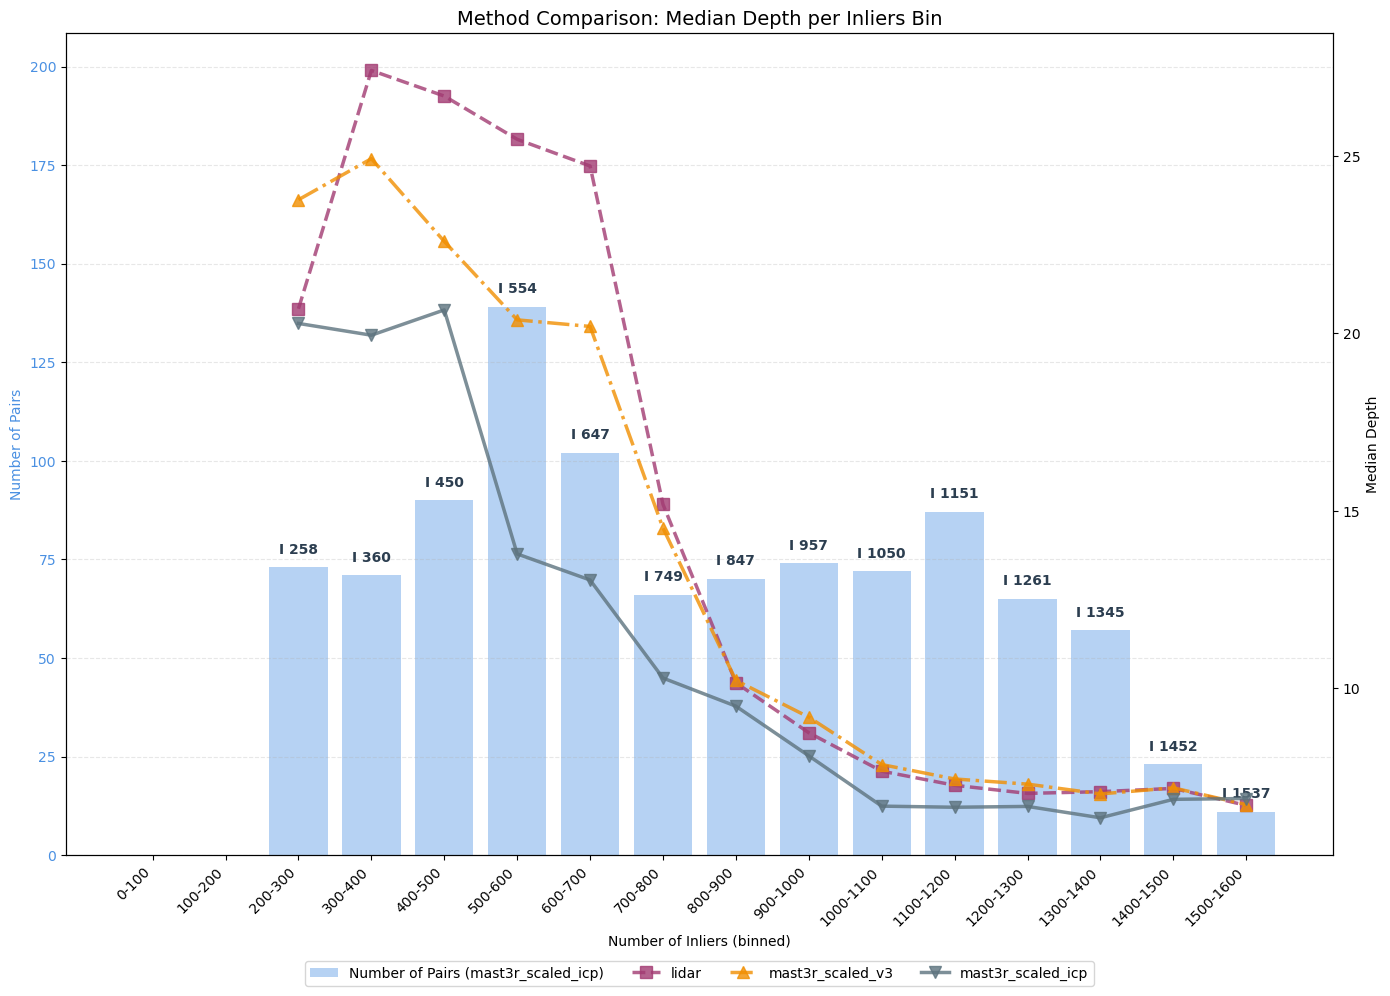


Comparison Statistics for median_depth:
lidar:
  Mean: 14.427
  Median: 9.451
  Min: 6.700
  Max: 27.406
mast3r_scaled_v3:
  Mean: 13.521
  Median: 9.703
  Min: 6.721
  Max: 24.921
mast3r_scaled_icp:
  Mean: 11.122
  Median: 8.795
  Min: 6.350
  Max: 20.659


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
reference_dataset = 'mast3r_scaled_icp'  # Dataset to use for histogram/binning
bin_width = 100  # Adjust bin width as needed
bin_by = 'num_inliers'  # Change this to 'num_matches' or 'num_inliers'

# Choose which metric to compare across methods
metric_to_compare = 'median_depth'  # Change this to any metric you want to compare

# Choose which methods to compare (can select multiple)
methods_to_compare = {
    # 'mast3r': {'color': '#2E86AB', 'marker': 'o', 'linestyle': '-'},
    'lidar': {'color': '#A23B72', 'marker': 's', 'linestyle': '--'},
    'mast3r_scaled_v3': {'color': '#F18F01', 'marker': '^', 'linestyle': '-.'},
    # 'mast3r_scaled_v4': {'color': '#C73E1D', 'marker': 'D', 'linestyle': ':'},
    'mast3r_scaled_icp': {'color': '#5D737E', 'marker': 'v', 'linestyle': '-'},
}

# Get the reference dataset for binning
df_ref = loaded_data[reference_dataset]
df_ref_ok = df_ref[df_ref['status'] == 'OK']

print(f"Using {reference_dataset} as reference for binning")
print(f"Binning by: {bin_by}")
print(f"Comparing metric: {metric_to_compare}")
print(f"Total pairs in reference: {len(df_ref)}, Successful pairs: {len(df_ref_ok)}")

# Validate binning column exists
if bin_by not in df_ref_ok.columns:
    print(f"Error: Column '{bin_by}' not found in reference dataset!")
    print(f"Available columns: {list(df_ref_ok.columns)}")
else:
    # Create bins based on reference dataset and selected binning column
    bins = range(0, int(df_ref_ok[bin_by].max()) + bin_width, bin_width)
    bin_column = f"{bin_by}_bin"
    df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)

    # Group reference data for histogram
    grouped_ref = df_ref_ok.groupby(bin_column)
    count_by_bin = grouped_ref.size()
    median_inliers_by_bin = grouped_ref["num_inliers"].median()

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Prepare data for all methods
    method_data = {}
    for method_name in methods_to_compare.keys():
        if method_name in loaded_data:
            df = loaded_data[method_name]
            df_ok = df[df['status'] == 'OK']
            
            # Apply the same binning to this method's data
            df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
            grouped = df_ok.groupby(bin_column)
            
            # Compute the metric for this method
            if metric_to_compare in df_ok.columns:
                metric_values = grouped[metric_to_compare].median()
                # Reindex to match the reference bins (fill missing bins with NaN)
                metric_values = metric_values.reindex(count_by_bin.index)
                method_data[method_name] = metric_values
            else:
                print(f"Warning: {metric_to_compare} not found in {method_name}")

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 10))

    # Bar plot: number of pairs per bin from reference dataset (left y-axis)
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, 
                   label=f"Number of Pairs ({reference_dataset})")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.tick_params(axis="y", labelcolor="#4A90E2")
    
    # Dynamic x-axis label based on binning variable
    x_label = "Number of Matches (binned)" if bin_by == 'num_matches' else "Number of Inliers (binned)"
    ax1.set_xlabel(x_label)
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], 
                        rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # Annotate bars with median inliers from reference dataset
    for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
        if not pd.isna(median_inliers):
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + max(count_by_bin) * 0.02,
                f"I {median_inliers:.0f}",
                ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
            )

    # Create secondary y-axis for the metric comparison
    ax2 = ax1.twinx()
    ax2.set_ylabel(f"{metric_to_compare.replace('_', ' ').title()}", color="black")

    # Plot the metric for each method
    line_plots = []
    for method_name, config in methods_to_compare.items():
        if method_name in method_data:
            line = ax2.plot(bin_midpoints, method_data[method_name], 
                           color=config['color'], marker=config['marker'], 
                           linestyle=config['linestyle'], label=method_name,
                           linewidth=2.5, markersize=8, alpha=0.8)
            line_plots.append((line[0], method_name))

    # Combine legends
    legend_items = [(bars, f"Number of Pairs ({reference_dataset})")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
              ncol=min(len(handles), 4), fontsize=10)

    # Add grid lines
    ax1.grid(axis="y", linestyle="--", alpha=0.3)

    # Dynamic title based on binning variable
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    plt.title(f"Method Comparison: {metric_to_compare.replace('_', ' ').title()} per {bin_label} Bin", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print(f"\nComparison Statistics for {metric_to_compare}:")
    print("=" * 50)
    for method_name in methods_to_compare.keys():
        if method_name in method_data:
            values = method_data[method_name].dropna()
            if len(values) > 0:
                print(f"{method_name}:")
                print(f"  Mean: {values.mean():.3f}")
                print(f"  Median: {values.median():.3f}")
                print(f"  Min: {values.min():.3f}")
                print(f"  Max: {values.max():.3f}")
            else:
                print(f"{method_name}: No data available")
        else:
            print(f"{method_name}: Not loaded")